# ExplainableAI Approach using SHAP Libraries 

In [1]:
!pip install shap

     |████████████████████████████████| 356 kB 7.6 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491643 sha256=399eac207a73f8e1020e359333dda9aa136cd95a9e65ef36c582b9d688049324
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random
import shap
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score, precision_score,f1_score, roc_curve,auc 
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from prettytable import PrettyTable

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AAIC ASSIGNMENT/Case Study 1/Case_Study_Preprocess_data.csv")
df.drop(columns=["Unnamed: 0","DOB","DOD"],axis=1,inplace=True)

In [4]:
X = df.drop(["PotentialFraud"],axis=1)
y = df["PotentialFraud"]

In [5]:
# Train Test Split
# train-test split as Train size= 80 and test size will be 20
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=0)

print("The Shape of X_train : ",X_train.shape)
print("The Shape of X_test  : ",X_test.shape)
print("="*100)
print("The Shape of y_train : ",y_train.shape)
print("The Shape of y_train : ",y_test.shape)

The Shape of X_train :  (446568, 49)
The Shape of X_test  :  (111643, 49)
The Shape of y_train :  (446568,)
The Shape of y_train :  (111643,)


In [6]:
# Normalizing data
scale_columns = ["Provider","BeneID","Race","State","County","InscClaimAmtReimbursed",
                 "AttendingPhysician","OperatingPhysician","OtherPhysician",
                 "ClmAdmitDiagnosisCode","DeductibleAmtPaid","DiagnosisGroupCode",
                 "Age_Of_Patients","Hospital_stay_Duration","Claim_Duration","Amount_left_reimburse"]

min_max_Scaling = MinMaxScaler()

In [7]:
from sklearn.externals.joblib import dump, load
def scaler_columns(data_tr,data_te,column):
  
  min_max_Scaling.fit(data_tr[column].values.reshape(-1,1))
  #dump(min_max_Scaling, '/content/drive/MyDrive/Colab Notebooks/AAIC ASSIGNMENT/Case Study 1/Post_training/scale_cols/'+column+'_std_scaler.bin', compress=True)

  scaler_train = min_max_Scaling.transform(data_tr[column].values.reshape(-1,1))
  
  scaler_test = min_max_Scaling.transform(data_te[column].values.reshape(-1,1))

  return scaler_train, scaler_test

In [8]:
for i in scale_columns: 
  X_train[i], X_test[i] = scaler_columns(X_train,X_test,i)  

# Best Model DecisionTree with ExplainableAI

In [9]:
# Decision Tree
# params = {'learning_rate':[0.01,0.03,0.05,0.1,1,10],
#          'n_estimators':[10,20,30,50,70,100],
#          'max_depth':[3,5,10]} 

params = {'max_depth':[5,10,30,50,70,100],
        'min_samples_split':[2,3,5,10],
        'criterion':['gini','entropy']}

dt = DecisionTreeClassifier(class_weight="balanced")
cross_val = RandomizedSearchCV(dt, param_distributions=params ,cv=5,n_jobs=-1,verbose=10)
cross_val.fit(X_train,y_train) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
    

In [10]:
print("The Best Parameters are ",cross_val.best_params_) 

The Best Parameters are  {'min_samples_split': 2, 'max_depth': 100, 'criterion': 'entropy'}


The Recall score of Train:  1.0
The Recall score of Test:  0.9795520706169594
The F1_Score of Train:  1.0
The F1_Score of Test:  0.9792072469550116


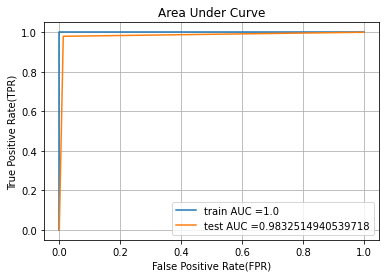

In [11]:
dt_best = cross_val.best_estimator_
dt_best.fit(X_train,y_train)

y_train_pred = dt_best.predict(X_train)
y_test_pred = dt_best.predict(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

#recall_score
recall_score_train = recall_score(y_train,y_train_pred)
recall_score_test = recall_score(y_test,y_test_pred)

#f1_score
f1_score_train = f1_score(y_train,y_train_pred)
f1_score_test = f1_score(y_test,y_test_pred)

print("="*50)
print("The Recall score of Train: ",recall_score_train)
print("The Recall score of Test: ",recall_score_test)
print("="*50)
print("The F1_Score of Train: ",f1_score_train)
print("The F1_Score of Test: ",f1_score_test)
print("="*50)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("Area Under Curve")
plt.grid()
plt.show()

# **SHAP (SHapley Additive exPlanations)** 

**Reference**:- https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html

In [12]:
explainer = shap.TreeExplainer(model=dt_best)
shap_values = explainer.shap_values(X_test) 

# Shap Force_plot

# Visualize for Single Prediction

In [13]:
y_test.iloc[1]

1

In [14]:
import shap
shap.initjs()

shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:])

# Visualize for Many Prediction

In [15]:
import shap
shap.initjs()

shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_test.iloc[:1000,:])

# Bar Chart of Mean Importance

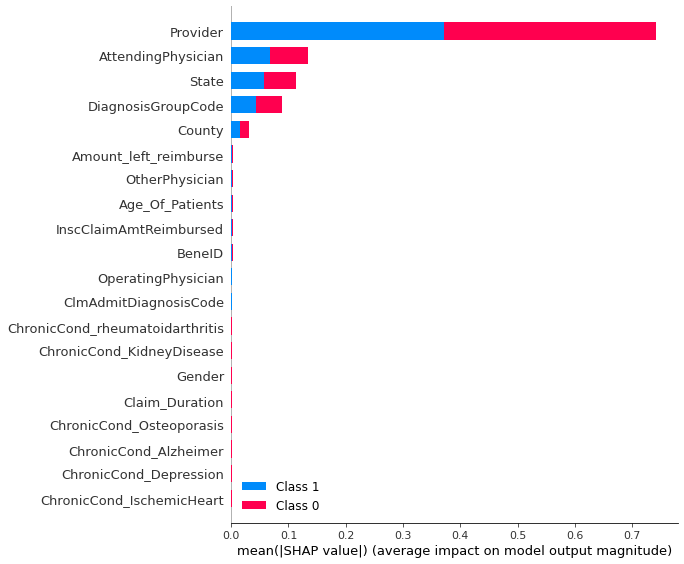

In [16]:
shap.summary_plot(shap_values, X_test.values, plot_type="bar", feature_names = X_test.columns)

# SHAP Summary_Plot

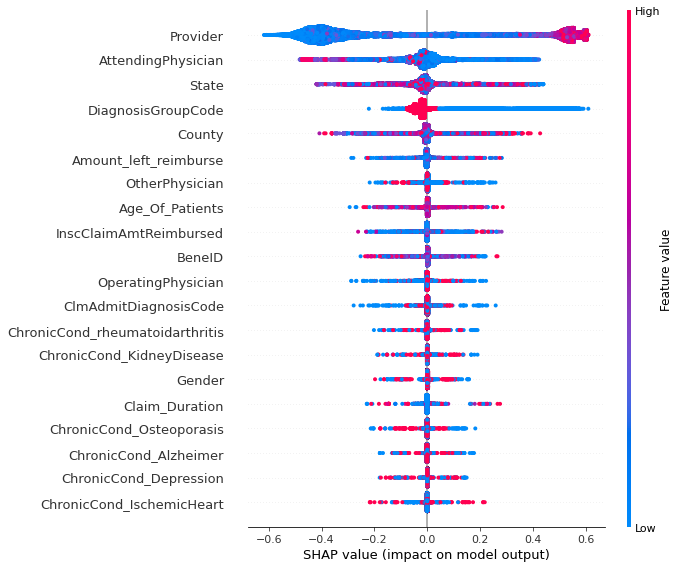

In [17]:
shap.summary_plot(shap_values[1], X_test.values,feature_names = X_test.columns)

# SHAP Dependence Plots

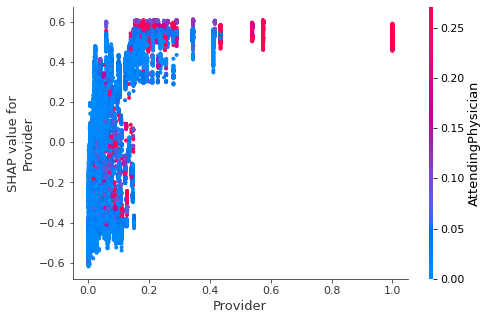

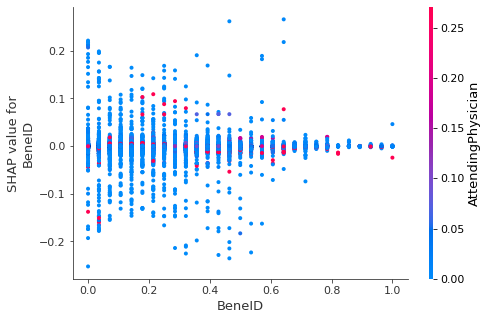

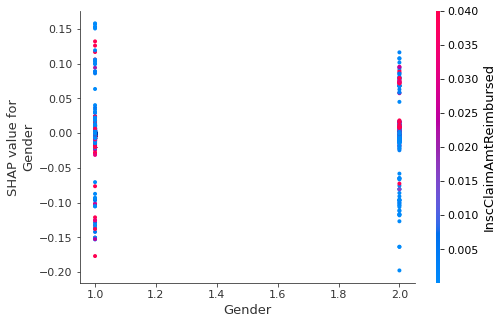

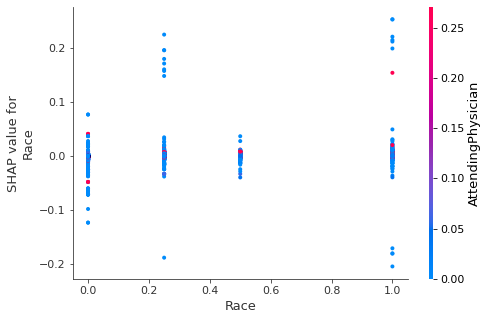

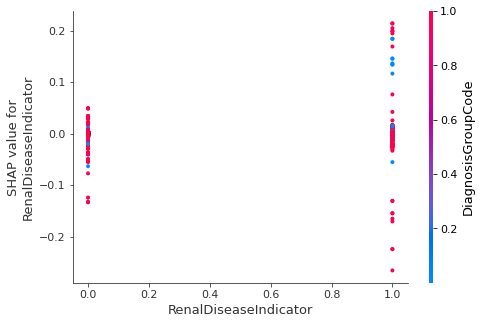

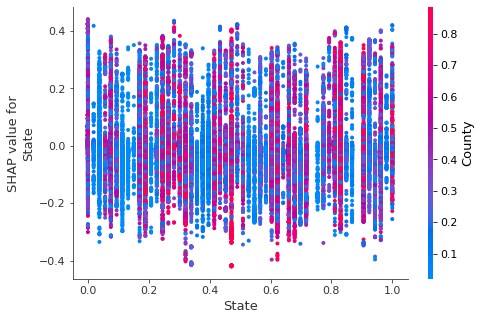

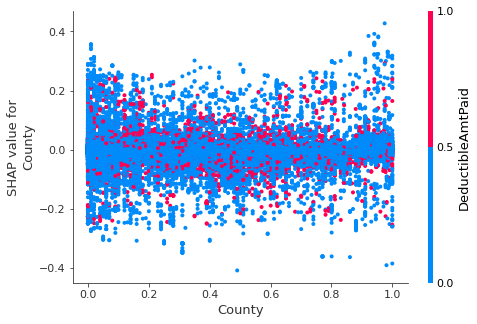

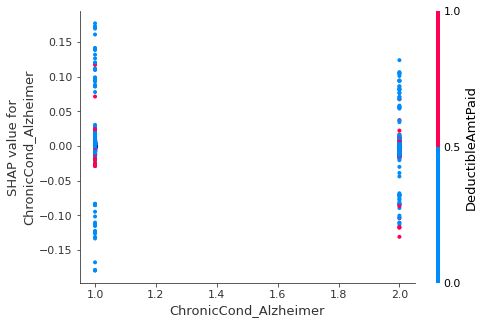

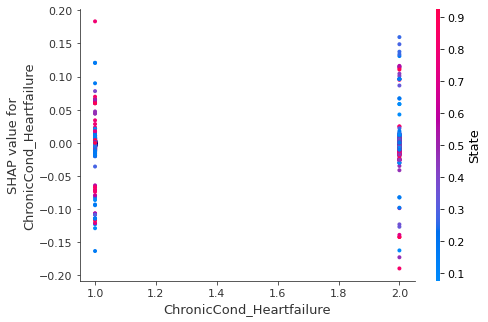

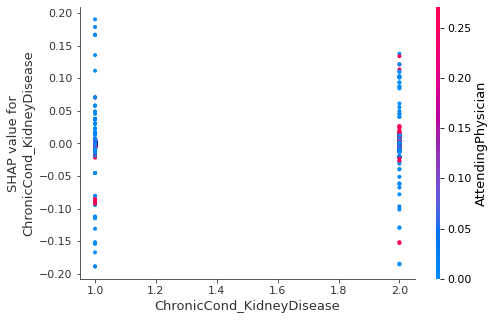

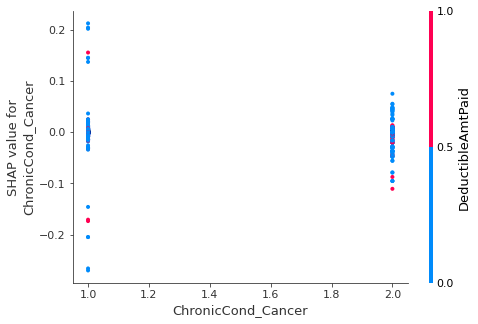

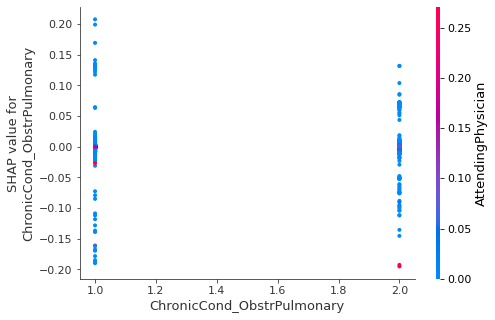

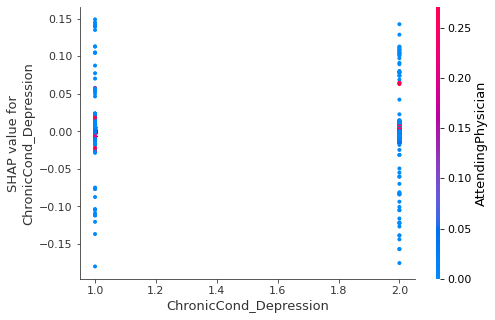

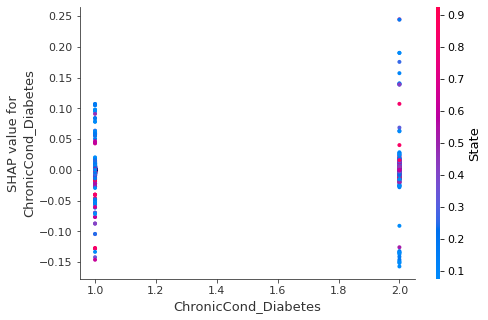

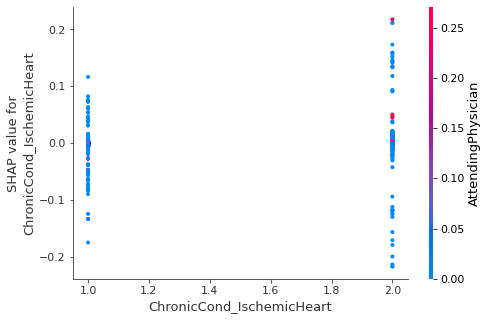

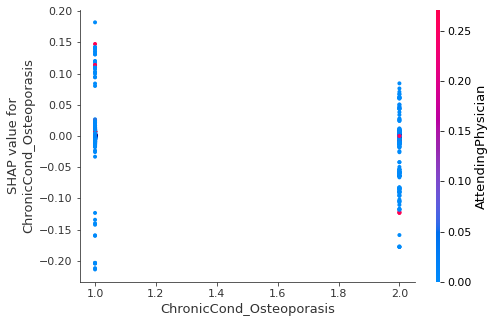

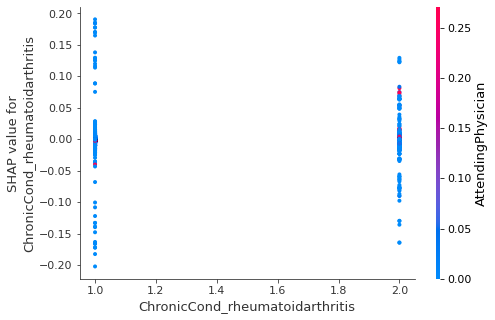

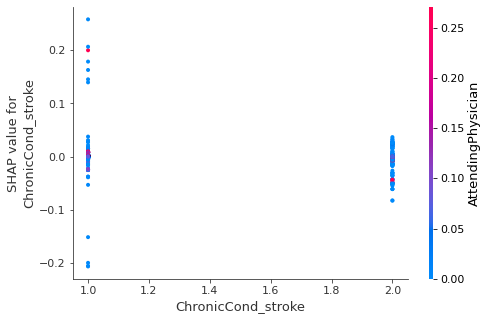

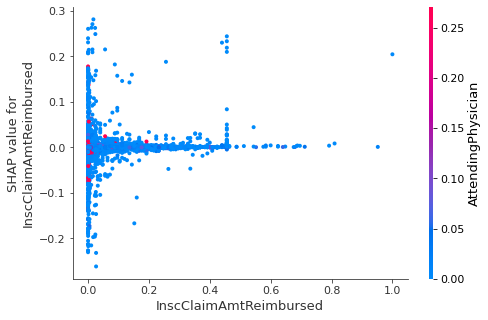

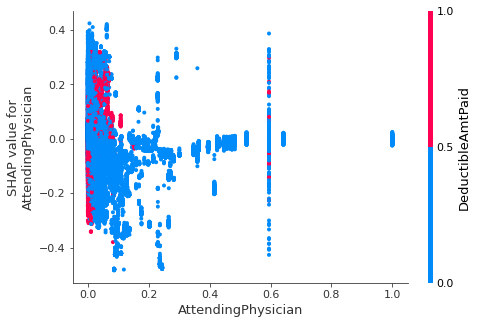

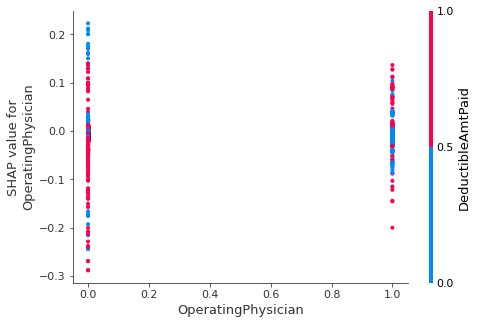

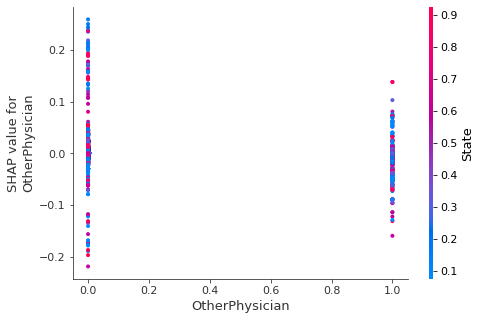

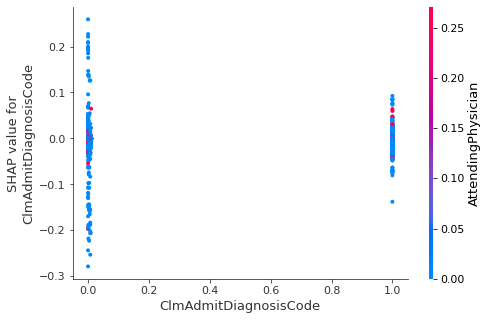

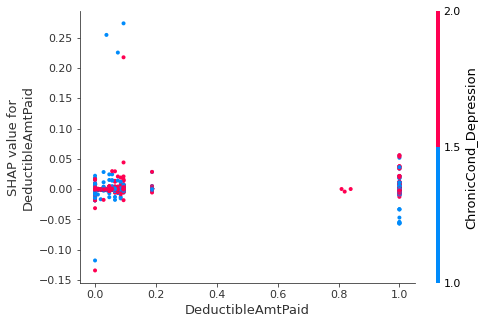

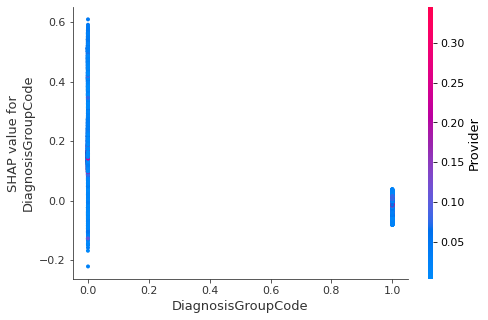

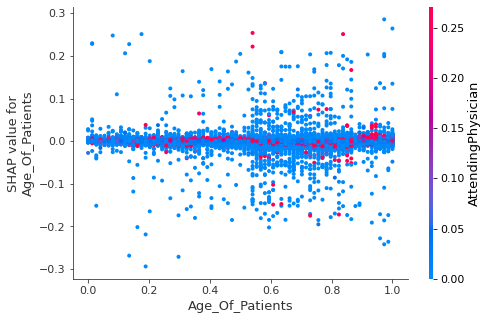

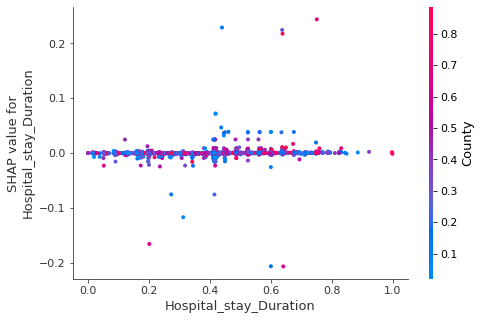

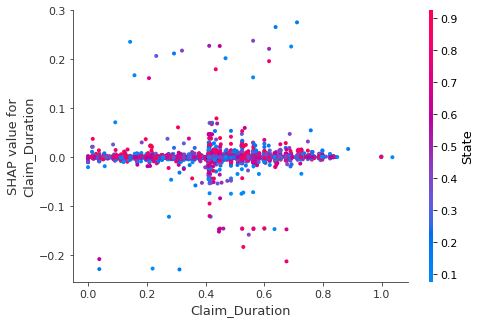

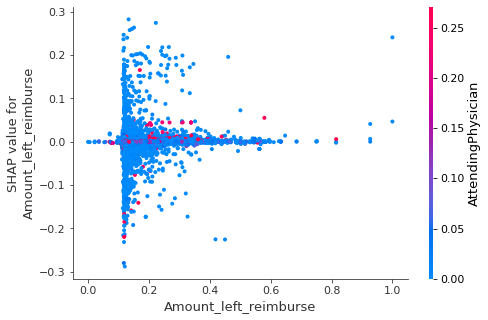

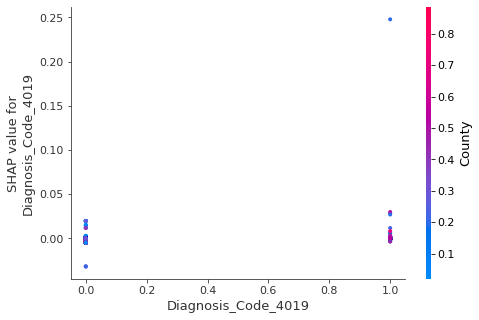

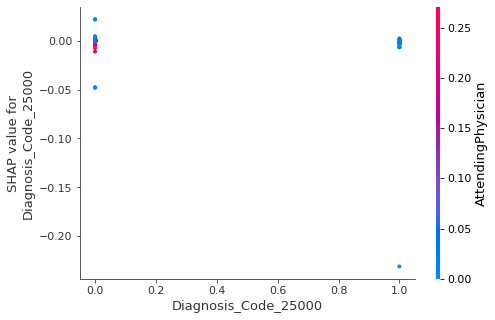

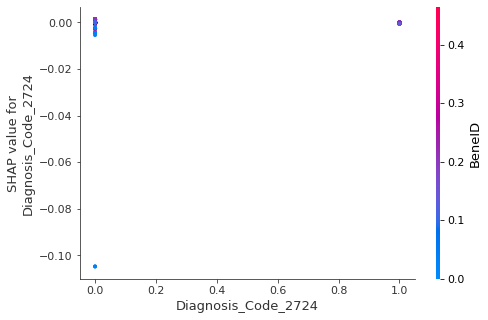

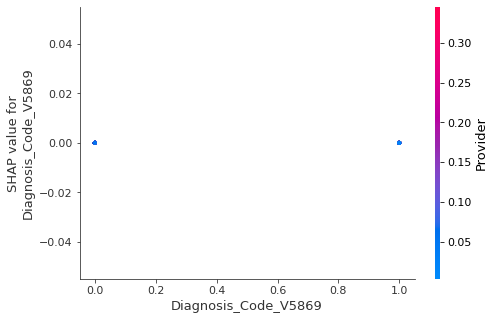

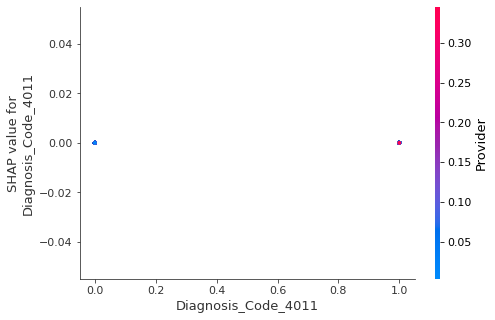

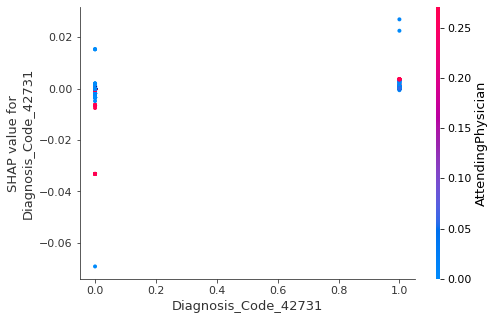

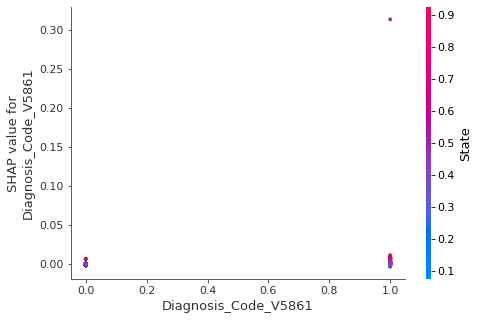

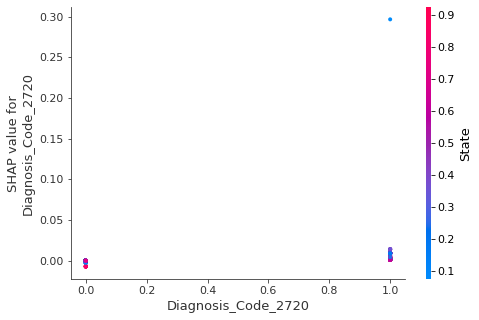

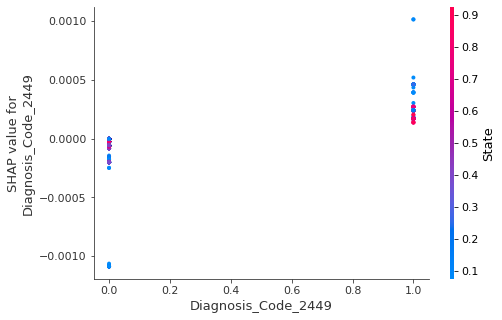

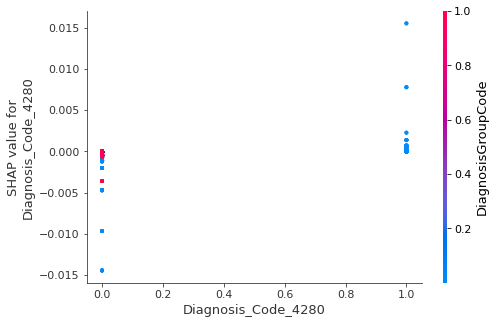

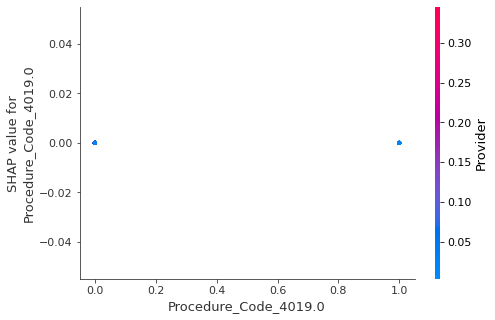

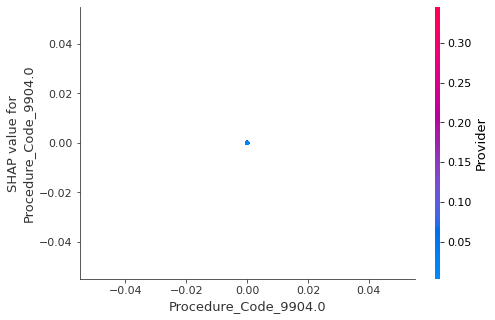

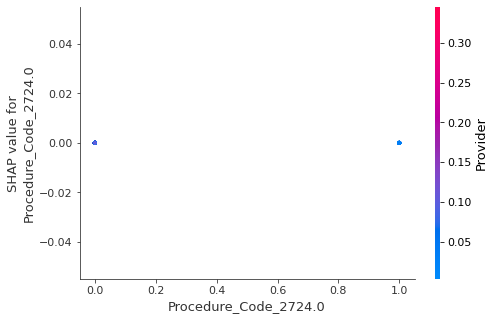

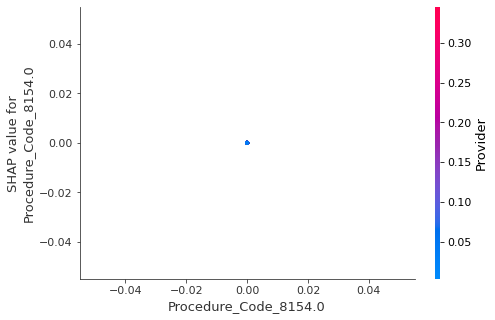

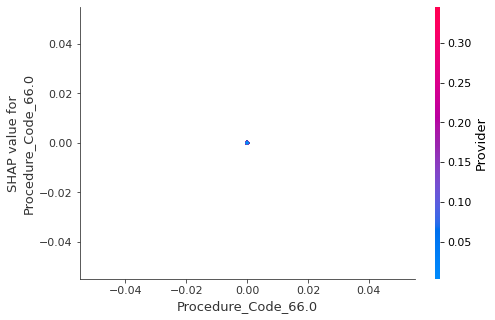

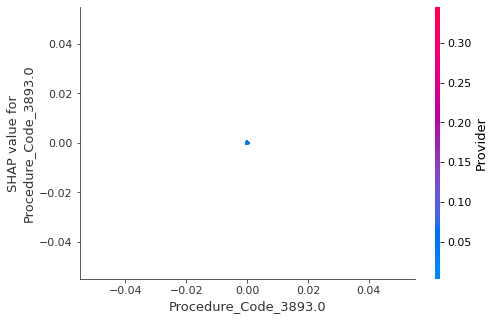

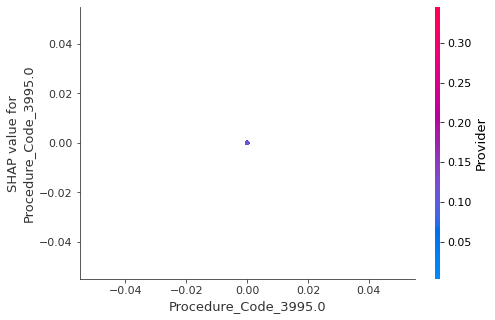

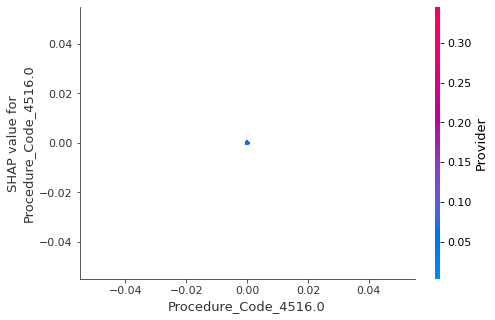

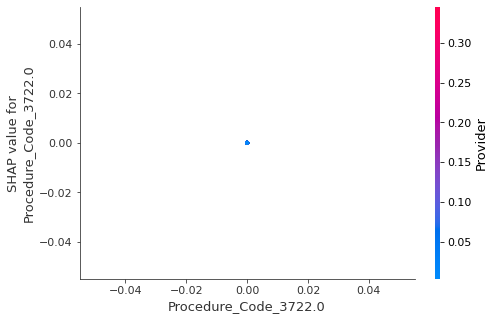

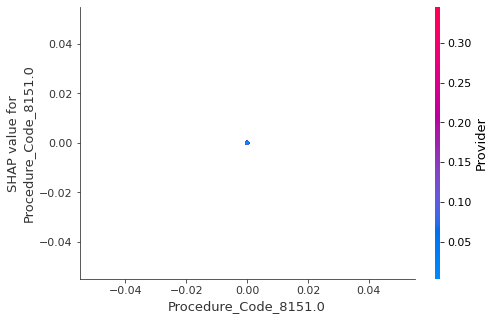

In [20]:
for name in X_test.columns:
  shap.dependence_plot(name, shap_values[1], X_test, feature_names= X_test.columns)